### 딥러닝 연습 - 분류

#### 데이터 다루기

In [29]:
# 데이터 가져오기, 평탄화

import pandas as pd

# CSV 파일 읽기
df = pd.read_csv("../healthcare-dataset-stroke-data.csv")

print(df.head())  # 데이터 확인
print('-----------------------------')
print(df.columns)
print('-----------------------------')
print(df['stroke'].value_counts())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
-----------------------------
Index(['id', 'gender', 'ag

In [30]:
# 데이터 체크

# 필요없는 특징(노이즈) 제거
df = df.drop(columns=['id'])


# 결측치 확인, 없애기
print(df.isnull().sum()) # 결측치 확인

df['bmi'].fillna(df['bmi'].mode()[0], inplace=True) # Embarked 결측치 채우기 (최빈값(가장 많이 등장한 값)으로 채우기)
    # fillna: 데이터의 결측값을 원하는 값으로 변경하는 메서드
    # mode()[0]: 특정 데이터의 최빈값을 반환. 최빈값은 여러개일 수 있으므로 첫 번째 최빈값([0])만 가져옴.

print(df.isnull().sum()) # 결측치 재확인


# One-Hot 인코딩: 각각의 값마다 열(속성)을 새로 만듦. 각 속성은 true, false값을 가짐.
df = pd.get_dummies(df, columns=["gender"])  # 원-핫 인코딩
df = pd.get_dummies(df, columns=["ever_married"])
df = pd.get_dummies(df, columns=["work_type"])
df = pd.get_dummies(df, columns=["Residence_type"])
df = pd.get_dummies(df, columns=["smoking_status"])

print(df.columns)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoki

C:\Users\jt341\AppData\Local\Temp\ipykernel_19604\3012449974.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mode()[0], inplace=True) # Embarked 결측치 채우기 (최빈값(가장 많이 등장한 값)으로 채우기)


In [ ]:
# 레이블 불균형 해결 - SMOTE: 일반적으로 가장 많이 사용. 기존 데이터 기반으로 새로운 데이터를 생성해 오버샘플링.
# 주의: 얘는 모든 데이터가 숫자일 때만 작동! 인코딩 먼저 해야 함.

from sklearn.preprocessing import StandardScaler  # 데이터 표준화 함수
from sklearn.model_selection import train_test_split  # 데이터 분할 함수

# [데이터 제작]
X = df.drop(columns=["stroke"])
y = df["stroke"]

y = pd.get_dummies(y) # y 원-핫 인코딩
y = y.values # numpy로 변경

scaler = StandardScaler() # X 표준화, numpy로 변경
X = scaler.fit_transform(X)

from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y) # X_smote, y_smote가 샘플링 후 결과물

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [ ]:
# x, y, test, train 나누기

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # test_size: 전체 데이터 중 test에 할당할 비율

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4088, 21), (1022, 21), (4088, 2), (1022, 2))

#### 모델 정의, 학습, 평가

In [ ]:
# 모델 정의하기(만들기), 하이퍼파라미터 튜닝

from keras.models import Sequential # 신경망 모델: 층을 순차적으로 쌓는 방식
from keras.layers import Dense # 완전 연결 레이어
from keras.optimizers import SGD,Adam # 최적화 알고리즘
from keras.layers import Dropout
from keras.regularizers import l2 # 정규화 

model = Sequential()

# 모델에 층 추가
    # model.add(Dense(32,input_shape=(64,),activation='relu', kernel_regularizer=l2(0.01)))
        # input_shape=(13,): 데이터의 특성 개수가 13개
        # Dense: 층간 모든 뉴런들이 가능한 모든 네트워크를 연결한 레이어 상태. 윗층이 2개, 아랫층이 3개면 6개의 네트워크가 다 연결된 것.
        # Dense(10, ...): 이 층이 출력으로 뽑는 노드(특성)가 10개
        # kernel_regularizer: 정규화 함수. l2는 L2 정규화
    # model.add(Dropout(0.1)) # 일부 뉴런의 연결선을 랜덤하게 비활성화. 과적합 해소용. 0.3 = 30% 비활성화

model.add(Dense(21,input_shape=(21,),activation='sigmoid')) # 입력층
    # input_shape=(a,): 데이터의 특성 개수가 a개
model.add(Dense(8,activation='sigmoid')) # 은닉층
model.add(Dense(4,activation='sigmoid')) # 은닉층
model.add(Dense(2,activation='sigmoid')) # 출력층
    # 출력층 노드가 a개: a개의 답 중 하나를 분류하는 문제라는 의미
    # 만약 이진 분류라 one-hot 인코딩을 안 한 상태라면 노드가 1개여야 함
    # 출력층 활성화 함수
        # 2중 분류: sigmoid
        # 다중 분류: softmax
        # 회귀: 없음

model.compile(Adam(learning_rate=0.002),'binary_crossentropy',metrics=['accuracy'])
    # 'binary_crossentropy': 손실 함수 - 모델이 얼마나 틀렸는지 측정
        # 2중 분류: binary_crossentropy
        # 다중 분류: categorical_crossentropy
        # 회귀: mse
    # *learning_rate 대신 lr을 사용하면 오류: 최신 버전은 learning_rate 속성만 지원
    
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684 (2.67 KB)

 Trainable params: 684 (2.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 학습

model_history=model.fit(x=X_train, y=y_train, epochs=30, batch_size=32, validation_data=(X_test,y_test))

y_pred = model.predict(X_test)

import numpy as np

y_test_origin = np.argmax(y_test,axis=1) # argmax: one-hot 인코딩으로 바뀐 상태를 되돌려서 결과를 평가할 수 있도록 함
y_pred_origin = np.argmax(y_pred,axis=1)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9556 - loss: 0.5334 - val_accuracy: 0.9393 - val_loss: 0.3224
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.2725 - val_accuracy: 0.9393 - val_loss: 0.2452
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9484 - loss: 0.2194 - val_accuracy: 0.9393 - val_loss: 0.2305
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.1873 - val_accuracy: 0.9393 - val_loss: 0.2269
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9567 - loss: 0.1796 - val_accuracy: 0.9393 - val_loss: 0.2237
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1783 - val_accuracy: 0.9393 - val_loss: 0.2194
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.1763 - val_accuracy: 0.9393 - val_loss: 0.2119
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9535 - loss: 0.1750 - val_accuracy: 0.

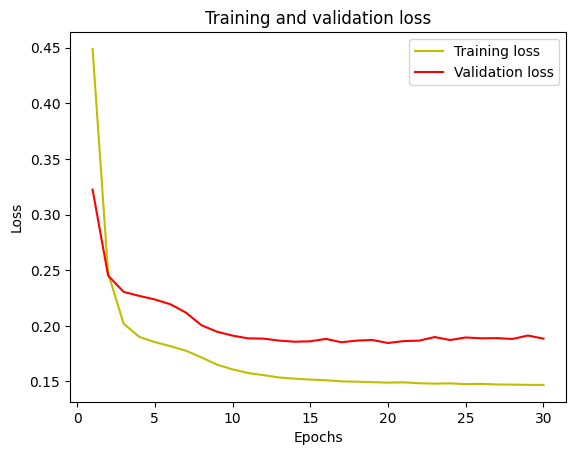

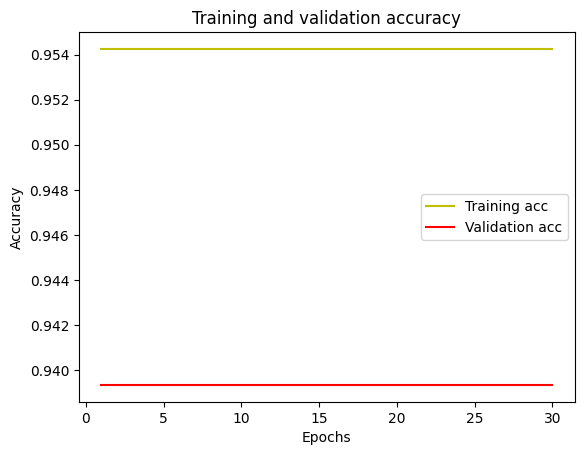

In [ ]:
# 학습 결과 시각화

import matplotlib.pyplot as plt
import seaborn as sns

# loss 시각화
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim() # y축 (최소값, 최대값) 설정
plt.legend()
plt.show()

# 정확도 시각화
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Confusion Matrix:
[[960   0]
 [ 62   0]]


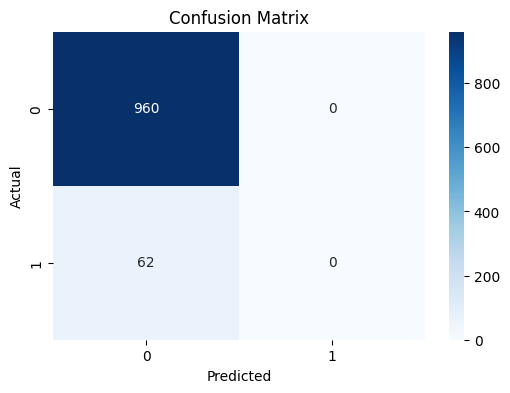

In [ ]:
# 이진 분류 모델 혼동 행렬 시각화
# 레이블(y)을 one-hot 인코딩했다면 되돌려야 함(아래에서 y_test_origin, y_pred_origin이 되돌린 데이터)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# [1] y_pred를 0 또는 1로 변환 (sigmoid 출력이니까 0.5 기준)
y_pred_labels = (y_pred_origin > 0.5).astype(int)

# [2] 혼동 행렬 계산
cm = confusion_matrix(y_test_origin, y_pred_labels)

# [3] 출력
print("Confusion Matrix:")
print(cm)

# [외전] 예쁘게 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()